In [8]:
#install.packages("h2o")
library(h2o)
library(dplyr)
library(ggplot2)
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 hours 28 minutes 
    H2O cluster version:        3.16.0.2 
    H2O cluster version age:    4 months and 26 days !!! 
    H2O cluster name:           H2O_started_from_R_chriskuo_wwa877 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.76 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.3 (2017-11-30) 


Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (4 months and 26 days)!
Please download and install the latest version from http://h2o.ai/download/”


R is connected to the H2O cluster: 
    H2O cluster uptime:         3 hours 28 minutes 
    H2O cluster version:        3.16.0.2 
    H2O cluster version age:    4 months and 26 days !!! 
    H2O cluster name:           H2O_started_from_R_chriskuo_wwa877 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.76 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.3 (2017-11-30) 


Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (4 months and 26 days)!
Please download and install the latest version from http://h2o.ai/download/”

I will use wineQualityReds.csv available at [this](https://www.kaggle.com/sagarnildass/red-wine-analysis-by-r/data) Kaggle site. Notice that this wine dataset is different from the data(wine) in the R package Rattle.data. The dataset should be converted to H2O data frame.

In [3]:
wine <-read.csv("/Users/chriskuo/Downloads/wineQualityReds.csv")
head(wine)
dim(wine)
# convert data to H2OFrame
colnames(wine)
x_col <- setdiff(colnames(wine), c('X','quality'))
wine_h <- as.h2o(wine)
head(wine_h)

X,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


[1] 1599   13

[1] "X"                    "fixed.acidity"        "volatile.acidity"    
 [4] "citric.acid"          "residual.sugar"       "chlorides"           
 [7] "free.sulfur.dioxide"  "total.sulfur.dioxide" "density"             
[10] "pH"                   "sulphates"            "alcohol"             
[13] "quality"

  |======================================================================| 100%


X,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [4]:
wine_train_test <- h2o.splitFrame(wine_h, 
                         ratios = c(0.4, 0.4), # must add up to less than 1.0
                         seed = 42)

train  <- wine_train_test[[1]]
test1  <- wine_train_test[[2]]
test2  <- wine_train_test[[3]]
dim(train)
dim(test1)
dim(test2)

[1] 643  13

[1] 637  13

[1] 319  13

An autoencoder neural network is an unsupervised learning algorithm that applies backpropagation. The purpose of an autoencoder is to learn a representation (encoding) from itself by setting the target values to be the inputs. In H2O it is as simple as setting "autoencoder = TRUE".

Autoencoder is typically applied to reduce a high-dimension data to low dimensionality. The original dataset has 13 dimensions. I will reduce to two dimensions to be plotted on a X-Y plane. This technique is also called “bottleneck” training because where the hidden layer in the middle is as small as two nodes.

In [5]:
model <- h2o.deeplearning(x = x_col,
                             training_frame = train,
                             model_id = "model",
                             autoencoder = TRUE,
                             hidden = c(5, 2, 5), 
                             epochs = 100,
                             activation = "Tanh")

  |======================================================================| 100%


In [6]:
test1_col <- h2o.deepfeatures(model, test1, layer = 2) %>% as.data.frame() 
quality <- as.vector(test1[,'quality'])
test1_col  <- cbind(test1_col,quality)
head(test1_col)
test1_col$quality <-as.character(test1_col$quality)
str(test1_col)

  |======================================================================| 100%


DF.L2.C1,DF.L2.C2,quality
0.5842709,0.019430296,5
0.5502871,-0.007619076,5
0.4966704,-0.022284476,5
0.5383756,0.188221181,5
0.3056534,-0.149781329,5
0.4387528,-0.217827335,5


'data.frame':	637 obs. of  3 variables:
 $ DF.L2.C1: num  0.584 0.55 0.497 0.538 0.306 ...
 $ DF.L2.C2: num  0.01943 -0.00762 -0.02228 0.18822 -0.14978 ...
 $ quality : chr  "5" "5" "5" "5" ...


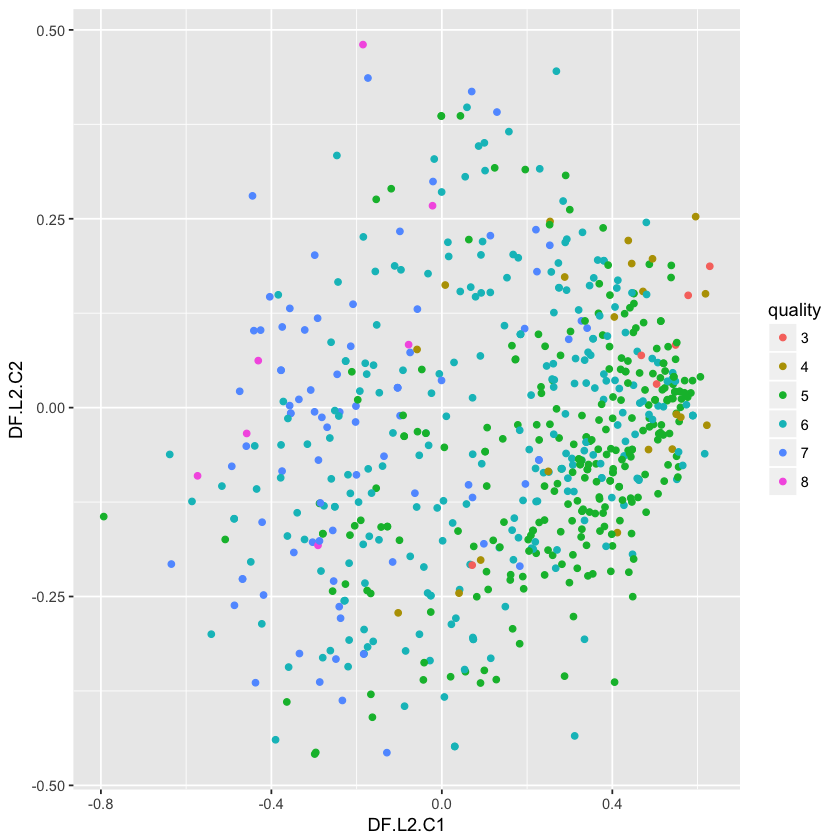

In [7]:
ggplot(test1_col, aes(x = DF.L2.C1, y = DF.L2.C2, color = quality)) +
  geom_point()